In [1]:
import os
import glob
from dotenv import load_dotenv
import gradio as gr

# imports for langchain, plotly and Chroma
from langchain.document_loaders import DirectoryLoader, TextLoader, PyPDFLoader
from langchain.text_splitter import CharacterTextSplitter, RecursiveCharacterTextSplitter
from langchain.schema import Document
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_chroma import Chroma
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import plotly.graph_objects as go
from langchain.memory import ConversationBufferMemory
from langchain.chains import ConversationalRetrievalChain
from langchain.embeddings import HuggingFaceEmbeddings

#pip install pypdf
#(llms) PS C:\Users\ghass> pip install jq

In [2]:

# price is a factor for our company, so we're going to use a low cost model
MODEL = "gpt-4o-mini"
db_name = "vector_Kaiserslautern_db"

In [3]:

# Load environment variables in a file called .env
load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')

In [4]:
from langchain_community.document_loaders import PyPDFLoader, TextLoader, CSVLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
import os
from collections import Counter

print(f"Current working directory: {os.getcwd()}")

def add_metadata(doc, doc_type):
    doc.metadata["doc_type"] = doc_type
    return doc

documents = []

# Folders to process
folders_to_process = [
    "Data/contacts", 
    "Data/extra", 
    "Data/klausur", 
    "Data/professoren", 
    "Data/Termin", 
    "Data/Vorpraktikum"
]

# Walk through each folder and load files
for folder in folders_to_process:
    if not os.path.exists(folder):
        print(f"Skipping (doesn't exist): {folder}")
        continue
    
    doc_type = os.path.basename(folder)
    
    print(f"\n{'='*50}")
    print(f"Processing folder: {folder} (type: {doc_type})")
    print(f"{'='*50}")
    
    for root, dirs, files in os.walk(folder):
        #  Skip .ipynb_checkpoints directories
        if '.ipynb_checkpoints' in root:
            continue
        
        for file in files:
            file_path = os.path.join(root, file)
            
            try:
                # PDF
                if file.endswith('.pdf'):
                    print(f"  Loading PDF: {file_path}")
                    loader = PyPDFLoader(file_path)
                    file_docs = loader.load()
                    documents.extend([add_metadata(doc, doc_type) for doc in file_docs])
                    print(f"    ✓ Loaded {len(file_docs)} pages")

                # Markdown
                elif file.endswith('.md'):
                    print(f"  Loading Markdown: {file_path}")
                    loader = TextLoader(file_path, encoding='utf-8')
                    file_docs = loader.load()
                    documents.extend([add_metadata(doc, doc_type) for doc in file_docs])
                    print(f"    ✓ Loaded 1 document")

                # CSV
                elif file.endswith('.csv'):
                    print(f"  Loading CSV: {file_path}")
                    loader = CSVLoader(file_path=file_path, encoding='utf-8')
                    csv_docs = loader.load()
                    documents.extend([add_metadata(doc, doc_type) for doc in csv_docs])
                    print(f"    ✓ Loaded {len(csv_docs)} rows")

                # Fallback JSON (optional)
                elif file.endswith('.json'):
                    print(f"  Loading JSON (as plain text): {file_path}")
                    loader = TextLoader(file_path, encoding='utf-8')
                    file_docs = loader.load()
                    documents.extend([add_metadata(doc, doc_type) for doc in file_docs])
                    print(f"    ✓ Loaded 1 document")
                    
            except Exception as e:
                print(f"    ✗ Error loading {file_path}: {e}")

print(f"\n{'='*50}")
print(f"Total documents loaded: {len(documents)}")
print(f"{'='*50}")

#  Split into chunks
if documents:
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=1000, 
        chunk_overlap=200,
        length_function=len,
        separators=["\n\n", "\n", " ", ""]
    )
    chunks = text_splitter.split_documents(documents)
    
    print(f"Total number of chunks: {len(chunks)}")
    print(f"Document types found: {set(doc.metadata['doc_type'] for doc in documents)}")
    
    # Show breakdown
    doc_type_counts = Counter(doc.metadata['doc_type'] for doc in documents)
    chunk_type_counts = Counter(chunk.metadata['doc_type'] for chunk in chunks)
    
    print(f"\nDocuments per type:")
    for doc_type, count in doc_type_counts.items():
        print(f"  - {doc_type}: {count} documents → {chunk_type_counts[doc_type]} chunks")
else:
    print(" No documents were loaded!")


Current working directory: D:\projects\llm_engineering\week5\Project_hochschule_kaiserslautern

Processing folder: Data/contacts (type: contacts)
  Loading JSON (as plain text): Data/contacts\pruefungsamt_rag.json
    ✓ Loaded 1 document

Processing folder: Data/extra (type: extra)
  Loading Markdown: Data/extra\Deutschland-Semesterticket.md
    ✓ Loaded 1 document

Processing folder: Data/klausur (type: klausur)
  Loading PDF: Data/klausur\Pruefungsplan_PO19.pdf
    ✓ Loaded 3 pages

Processing folder: Data/professoren (type: professoren)
  Loading Markdown: Data/professoren\Albert Meij.md
    ✓ Loaded 1 document
  Loading Markdown: Data/professoren\Andreas Steil.md
    ✓ Loaded 1 document
  Loading Markdown: Data/professoren\arl-Heinz Helmstädter.md
    ✓ Loaded 1 document
  Loading Markdown: Data/professoren\Christian M. Thurnes.md
    ✓ Loaded 1 document
  Loading Markdown: Data/professoren\Christian Schumann.md
    ✓ Loaded 1 document
  Loading Markdown: Data/professoren\Constanti

In [ ]:
doc_types = set(chunk.metadata['doc_type'] for chunk in chunks)
print(f"Document types found: {', '.join(doc_types)}")

In [ ]:
for chunk in chunks:
    if 'Steffen' in chunk.page_content:  #Lancaster / Avery
        print(chunk)
        print("_________")

In [5]:
len(documents)

52

In [6]:
documents[30]

Document(metadata={'source': 'Data/professoren\\Norbert Gilbert.md', 'doc_type': 'professoren'}, page_content='# Prof. Dr.-Ing. Norbert Gilbert\n\n**Campus:** Kaiserslautern  \n**Raum:** F1.029  \n**Telefon:** +49 631 3724-2303, +49 631 3724-2105  \n**E-Mail:** norbert.gilbert(at)hs-kl(dot)de  \n**Fachbereich:** Angewandte Ingenieurwissenschaften  \n\n---\n\n## Lehrgebiete\n- Strömungslehre  \n- Strömungsmaschinen  \n- Computational Fluid Dynamics (CFD)  \n- Experimentalphysik  \n\n## Forschungsgebiete\n- CFD mit OpenSource Programmen (Salome, OpenFOAM, ParaView)  \n- Simulation partikulärer Strömungen mittels DEM (YADE, Liggghts)  \n- Hydrodynamik Vertikaler Windenergieanlagen (VAWT)  \n- Strömungsmesstechnik (LDA, PIV)  \n- Flugzeugvereisung (in-flight icing), BMBF Projekt  \n\n## Sprechstunde\n- Montag 13:00 - 13:50 Uhr und nach Vereinbarung  \n')

In [7]:
import shutil, os

db_path = "vector_Kaiserslautern_db"

if os.path.exists(db_path):
    shutil.rmtree(db_path, ignore_errors=True)
    print(f"Deleted: {db_path}")
else:
    print("Directory does not exist.")

Deleted: vector_Kaiserslautern_db


In [8]:
# Put the chunks of data into a Vector Store that associates a Vector Embedding with each chunk
# Chroma is a popular open source Vector Database based on SQLLite

embeddings = OpenAIEmbeddings()

# If you would rather use the free Vector Embeddings from HuggingFace sentence-transformers
# Then replace embeddings = OpenAIEmbeddings()
# with:
# from langchain.embeddings import HuggingFaceEmbeddings
# embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

# Delete if already exists

if os.path.exists(db_name):
    Chroma(persist_directory=db_name, embedding_function=embeddings).delete_collection()

# Create vectorstore

vectorstore = Chroma.from_documents(documents=chunks, embedding=embeddings, persist_directory=db_name)
print(f"Vectorstore created with {vectorstore._collection.count()} documents")

Vectorstore created with 173 documents


In [9]:
# Let's investigate the vectors

collection = vectorstore._collection
count = collection.count()

sample_embedding = collection.get(limit=1, include=["embeddings"])["embeddings"][0]
dimensions = len(sample_embedding)
print(f"There are {count:,} vectors with {dimensions:,} dimensions in the vector store")

There are 173 vectors with 1,536 dimensions in the vector store


In [12]:
# # Prework (with thanks to Jon R for identifying and fixing a bug in this!)

# result = collection.get(include=['embeddings', 'documents', 'metadatas'])
# vectors = np.array(result['embeddings'])
# documents = result['documents']
# metadatas = result['metadatas']
# doc_types = [metadata['doc_type'] for metadata in metadatas]
# colors = [['blue', 'green', 'red', 'orange','yellow'][['contacts', 'Termin', 'klausur', 'professoren', 'extra'].index(t)] for t in doc_types]

SyntaxError: unterminated string literal (detected at line 8) (3425806112.py, line 8)

In [13]:
# # Prework (with thanks to Jon R for identifying and fixing a bug in this!)

# result = collection.get(include=['embeddings', 'documents', 'metadatas'])
# vectors = np.array(result['embeddings'])
# documents = result['documents']
# metadatas = result['metadatas']
# color_map = ['blue', 'green', 'red', 'orange', 'yellow', 'brown']  # added a color for Vorpraktikum
# doc_type_list = ['contacts', 'Termin', 'klausur', 'professoren', 'extra', 'Vorpraktikum']

# colors = [color_map[doc_type_list.index(t)] for t in doc_types]


In [15]:
# Prework
result = collection.get(include=['embeddings', 'documents', 'metadatas'])
vectors = np.array(result['embeddings'])
documents = result['documents']
metadatas = result['metadatas']
doc_types = [metadata['doc_type'] for metadata in metadatas]

#  Define all types and their colors (added 'Vorpraktikum')
type_color_map = {
    'contacts': 'blue',
    'Termin': 'green',
    'klausur': 'red',
    'professoren': 'orange',
    'extra': 'yellow',
    'Vorpraktikum': 'purple'
}

#  Assign colors safely
colors = [type_color_map.get(t, 'gray') for t in doc_types]


In [ ]:
# # We humans find it easier to visalize things in 2D!
# # Reduce the dimensionality of the vectors to 2D using t-SNE
# # (t-distributed stochastic neighbor embedding)

# tsne = TSNE(n_components=2, random_state=42)
# reduced_vectors = tsne.fit_transform(vectors)

# # Create the 2D scatter plot
# fig = go.Figure(data=[go.Scatter(
#     x=reduced_vectors[:, 0],
#     y=reduced_vectors[:, 1],
#     mode='markers',
#     marker=dict(size=5, color=colors, opacity=0.8),
#     text=[f"Type: {t}<br>Text: {d[:100]}..." for t, d in zip(doc_types, documents)],
#     hoverinfo='text'
# )])

# fig.update_layout(
#     title='2D Chroma Vector Store Visualization',
#     scene=dict(xaxis_title='x',yaxis_title='y'),
#     width=800,
#     height=600,
#     margin=dict(r=20, b=10, l=10, t=40)
# )

# fig.show()

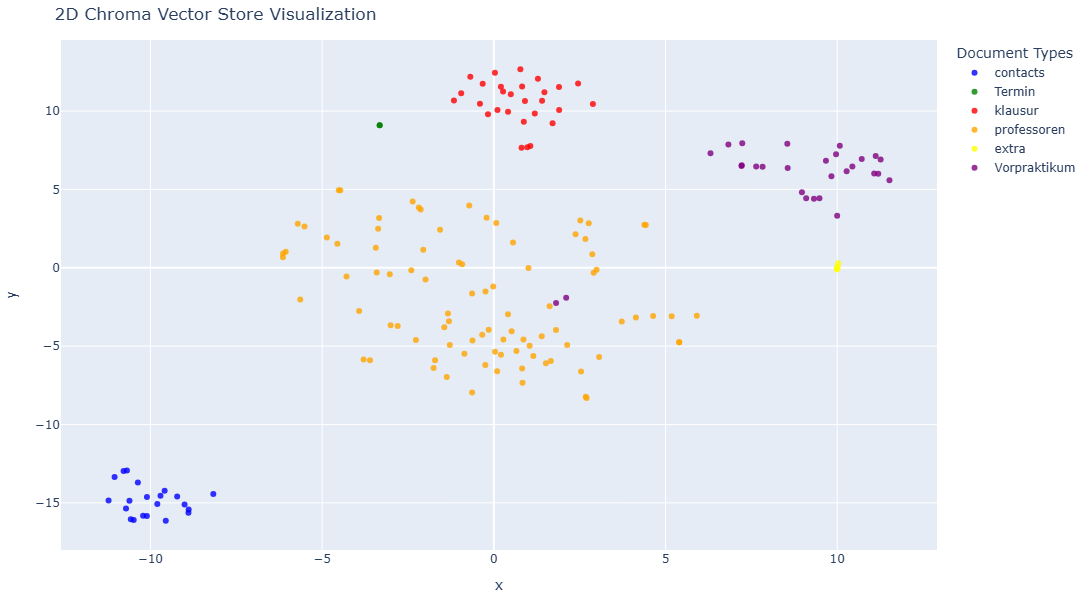

In [16]:
tsne = TSNE(n_components=2, random_state=42)
reduced_vectors = tsne.fit_transform(vectors)

fig = go.Figure()
for doc_type, color in type_color_map.items():
    indices = [i for i, t in enumerate(doc_types) if t == doc_type]
    if not indices:
        continue
    fig.add_trace(go.Scatter(
        x=reduced_vectors[indices, 0],
        y=reduced_vectors[indices, 1],
        mode='markers',
        marker=dict(size=6, color=color, opacity=0.8),
        name=doc_type,  #  legend label
        text=[f"Type: {doc_type}<br>Text: {documents[i][:100]}..." for i in indices],
        hoverinfo='text'
    ))

fig.update_layout(
    title='2D Chroma Vector Store Visualization',
    xaxis_title='x',
    yaxis_title='y',
    width=800,
    height=600,
    margin=dict(r=20, b=10, l=10, t=40),
    legend_title_text='Document Types'
)
fig.show()


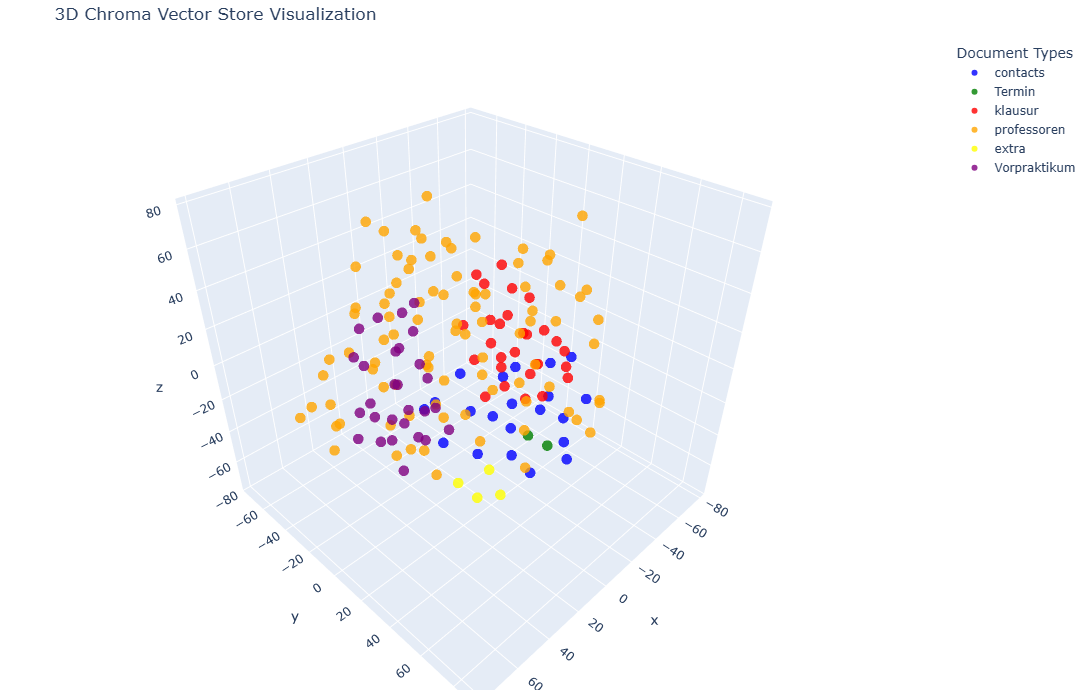

In [17]:
# Let's try 3D!

tsne = TSNE(n_components=3, random_state=42)
reduced_vectors = tsne.fit_transform(vectors)

fig = go.Figure()
for doc_type, color in type_color_map.items():
    indices = [i for i, t in enumerate(doc_types) if t == doc_type]
    if not indices:
        continue
    fig.add_trace(go.Scatter3d(
        x=reduced_vectors[indices, 0],
        y=reduced_vectors[indices, 1],
        z=reduced_vectors[indices, 2],
        mode='markers',
        marker=dict(size=6, color=color, opacity=0.8),
        name=doc_type,
        text=[f"Type: {doc_type}<br>Text: {documents[i][:100]}..." for i in indices],
        hoverinfo='text'
    ))

fig.update_layout(
    title='3D Chroma Vector Store Visualization',
    scene=dict(xaxis_title='x', yaxis_title='y', zaxis_title='z'),
    width=900,
    height=700,
    margin=dict(r=20, b=10, l=10, t=40),
    legend_title_text='Document Types'
)
fig.show()


In [18]:
# set up a new conversation memory for the chat
memory = ConversationBufferMemory(memory_key='chat_history', return_messages=True)

# putting it together: set up the conversation chain with the GPT 4o-mini LLM, the vector store and memory
conversation_chain = ConversationalRetrievalChain.from_llm(llm=llm, retriever=retriever, memory=memory)

C:\Users\ghass\AppData\Local\Temp\ipykernel_18280\239925141.py:2: LangChainDeprecationWarning:

Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/



NameError: name 'llm' is not defined

In [19]:
# Let's investigate what gets sent behind the scenes

from langchain_core.callbacks import StdOutCallbackHandler

llm = ChatOpenAI(temperature=0.7, model_name=MODEL)

memory = ConversationBufferMemory(memory_key='chat_history', return_messages=True)

retriever = vectorstore.as_retriever()

### here we add the callbacks
conversation_chain = ConversationalRetrievalChain.from_llm(llm=llm, retriever=retriever, memory=memory, callbacks=[StdOutCallbackHandler()])

In [20]:
# Let's try a simple question

query = "welche raum und wann wird den klausur aktor und sensor von PO2019 ?"
result = conversation_chain.invoke({"question": query})
answer = result["answer"]
print("\nAnswer:", answer)



> Entering new ConversationalRetrievalChain chain...


> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
System: Use the following pieces of context to answer the user's question.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
----------------
Prüfungsplan für das WiSe 2025/2026 des Fachbereichs AINGStand: 09.10.2025
alle Bachelor-Studiengänge (PO 2019)
Master-Studiengang ET/IT (PO 2021)
BasisD BasisDBasisD Rech Zuweis BasisD Zuweis Rech BasisD BasisD BD BD BD BD BD BD BD BD BD BD BD BD BD BD BD BD BD BD BD Rech Fixe VorgabeRech Rech
Lehrgebiet
ArtPNR Tag Prüfungsdatum Dauer Prüfer/-in Zweitprüfer/-in (gem. 
ABPO, §8)
ET-ATET-ATITET-ENEIMB-AddMB-AMMB-DPEMB-EngMB-LKMB-PTMB-VTMTWI-ABWI-AddWI-EngWI-ENWI-MBWI-PTWI-RE
Aktor- und Sensortechnik Ba 1827 Mo 26.01.2026 90 min 11:00 12:30 Geromiller Urschel 4 - 4 - - - - - - - - - - - - - - - - Do 20.11.2025 Mo 19.01.2026
Aktorik und Sensorik Ba 1

In [ ]:
# create a new Chat with OpenAI
llm = ChatOpenAI(temperature=0.7, model_name=MODEL)

# set up the conversation memory for the chat
memory = ConversationBufferMemory(memory_key='chat_history', return_messages=True)

# the retriever is an abstraction over the VectorStore that will be used during RAG; k is how many chunks to use
retriever = vectorstore.as_retriever(search_kwargs={"k": 25})

# putting it together: set up the conversation chain with the GPT 3.5 LLM, the vector store and memory
conversation_chain = ConversationalRetrievalChain.from_llm(llm=llm, retriever=retriever, memory=memory)

In [ ]:
def chat(question, history):
    result = conversation_chain.invoke({"question": question})
    return result["answer"]

In [ ]:
view = gr.ChatInterface(chat, type="messages").launch(inbrowser=True, share=True)